In [97]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [98]:
#@save
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [99]:
#@save
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [100]:
#@save
class EncoderBlock(nn.Module):
    """Transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(
            num_hiddens, num_heads, dropout,
            use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [101]:
#@save
class TransformerEncoder(d2l.Encoder):
    """Transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，
        # 然后再与位置编码相加。
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

In [102]:
class DecoderBlock(nn.Module):
    """解码器中第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        #@xingj: 这个i就是指当前在解码器的哪一层
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout) 

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同一时间处理，
        # 因此state[2][self.i]初始化为None。
        # 预测阶段，输出序列是通过词元一个接着一个解码的，
        # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
        if self.training:
            key_values = X
            # train_key_values.shape = torch.Size([25, 10, 32]) = (batch_size,max_len,dims)
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        '''
        在训练阶段，key_values 通常就是当前解码器输入 X 的一个副本。
        在预测（或生成）阶段，key_values 是通过在当前解码器层的先前输出（如果存在）和当前输入 X 的拼接来构建的，这允许模型在生成序列的每个步骤中考虑到之前生成的所有词元。

        因此，state[2][self.i] = key_values 这行代码的意思是：将当前解码步骤计算得到的 key_values 存储到当前解码器层的内部状态中，以便在后续的解码步骤中使用。这在预测阶段特别重要，因为它允许模型基于之前生成的所有词元来生成下一个词元。
        '''
        if self.training:
            batch_size, num_steps, _ = X.shape
            # dec_valid_lens的开头:(batch_size,num_steps),
            # 其中每一行是[1,2,...,num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # 自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # 编码器－解码器注意力。
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [103]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            # num_layers就是解码器的块数，每个块都编了号为i
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        # @Xingj: 如果len=3.那么就是[[None,None,None],[None,None,None]],这里的[None]外面包裹的[]和*结合了变成[]*
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

In [104]:
class EncoderDecoder(d2l.Classifier):
    """The base class for the encoder--decoder architecture.

    Defined in :numref:`sec_encoder-decoder`"""
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_all_outputs = self.encoder(enc_X, *args)
        # enc_all_outputs.shape = [batch_size, max_len, dim] = [13, 10, 32]
        # args里包含enc_valid_lens，即每个样本的合法长度
        dec_state = self.decoder.init_state(enc_all_outputs, *args)
        # Return decoder output only
        return self.decoder(dec_X, dec_state)

    def predict_step(self, batch, device, num_steps,
                     save_attention_weights=False):
        """Defined in :numref:`sec_seq2seq_training`"""
        batch = [d2l.to(a, device) for a in batch]
        src, tgt, src_valid_len, _ = batch  
        enc_all_outputs = self.encoder(src, src_valid_len)
        dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
        outputs, attention_weights = [d2l.expand_dims(tgt[:, 0], 1), ], []
        for _ in range(num_steps):
            Y, dec_state = self.decoder(outputs[-1], dec_state)
            outputs.append(d2l.argmax(Y, 2))
            # Save attention weights (to be covered later)
            if save_attention_weights:
                attention_weights.append(self.decoder.attention_weights)
        return d2l.concat(outputs[1:], 1), attention_weights

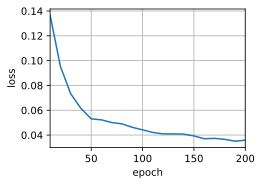

In [105]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 13, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [106]:
train_iter

In [107]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """Predict for sequence to sequence.

    Defined in :numref:`sec_utils`"""
    # Set `net` to eval mode for inference
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # Add the batch axis
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # Add the batch axis
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # We use the token with the highest prediction likelihood as input
        # of the decoder at the next time step
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

TypeError: expected Tensor as element 0 in argument 0, but got NoneType

In [ ]:
engs = ["i lost .", 'go .', 'he\'s calm .', 'i\'m home .']
fras = ['j\'ai perdu .', 'va !',  'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    src_sentence = eng
    save_attention_weights = True
    net.eval()
    src_tokens_temp = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']] #放平心态， 那些刚参加工作，刚开始用IDE的人也得学怎么调试
    enc_valid_len = torch.tensor([len(src_tokens_temp)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens_temp, num_steps, src_vocab['<pad>'])
    # Add the batch axis
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # Add the batch axis
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # We use the token with the highest prediction likelihood as input
        # of the decoder at the next time step
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
        ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [34]:
decoder.blks.block1.train_key_values.shape
#decoder.blks.block1.dec_valid_lens

tensor([[[ 2.1101e-01, -1.3326e-02, -1.4017e-01, -2.0081e-01,  1.1387e-01,
           2.6479e-01, -8.0771e-01,  1.9017e-01, -6.5017e-01,  2.2773e-01,
           2.6495e-02,  3.2607e-01,  4.3781e-01,  8.0577e-01, -1.0136e-01,
           9.7635e-01, -8.6175e-02,  3.1511e-02, -2.8533e-02,  1.7745e-01,
           4.3617e-01,  3.3914e-01,  3.7934e-01,  5.4906e-02,  1.4365e-01,
           9.6172e-03, -4.6282e-02, -2.2676e-01, -2.1657e-01, -5.4141e-01,
           2.6376e-01, -2.3821e-01],
         [-2.6688e-01, -1.3665e+00,  2.0095e-01,  9.1013e-01,  5.5623e-01,
           2.0883e-01,  1.4293e+00, -1.5567e+00, -9.1442e-01, -6.2310e-01,
           1.0830e+00, -1.0493e+00,  1.1374e+00,  5.6923e-01, -2.0221e+00,
          -2.5624e-01,  6.9478e-01, -1.3108e-01, -1.0379e+00,  1.5504e-02,
           1.9774e+00,  2.8793e-01, -8.1488e-01, -2.6101e-01,  1.2317e+00,
          -3.5889e-01, -1.0481e-02,  2.7610e-01,  8.5351e-02, -4.5077e-01,
          -2.4063e-01,  3.7329e-01],
         [-1.0170e+00, -1.